In [70]:
import pickle
import os
from itertools import islice
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Audio, display
from umap import UMAP
from matplotlib.cm import rainbow, inferno

from siren import to_indices
from utils.ffmpeg import auread
from utils.specshow import specshow
from utils.itertools import chunks
from utils.imutil import imshow

In [2]:
def load_cache(name):
    with open(f'cache/{name}.pkl', 'rb') as f:
        return pickle.load(f)
    
grouped = load_cache('grouped')

In [3]:
def get_unit_timing(annotation_fn, y, sr, amp, gloss=True):
    if not os.path.exists(annotation_fn):
        print('No annotations available:', annotation_fn)
        return
    annotations = pd.read_csv(annotation_fn, sep='\t')
    timing = []
    for row in annotations.values:
        begin_sec, end_sec = row[3], row[4]
        begin_amp = int(begin_sec * amp_rate)
        end_amp = int(end_sec * amp_rate)
        unit = row[-1]
        if gloss:
            unit = unit[0]
        yield begin_amp, end_amp, unit

In [4]:
# timing_grouped = defaultdict(list)

# for stem in grouped:
#     audio_fn = f'data/{stem}.wav'
#     annotation_fn = f'data/{stem}.Table.1.selections.txt'
#     if not os.path.exists(annotation_fn):
#         continue
#     for begin_amp, end_amp, unit in get_unit_timing(annotation_fn, y, sr, amp):
#         timing_grouped[unit].append((stem, begin_amp, end_amp))

In [10]:
sr = 44100
hop_length = 512
amp_rate = sr / hop_length

def get_unit_fingerprints(amp, timing):
    for begin_amp, end_amp, unit in timing:
        yield amp[begin_amp:end_amp], unit

In [11]:
fingerprints_grouped = defaultdict(list)
stems_grouped = defaultdict(list)

units = []
fingerprints = []
stems = []

for stem in grouped:
    audio_fn = f'data/{stem}.wav'
    annotation_fn = f'data/{stem}.Table.1.selections.txt'
    if not os.path.exists(annotation_fn):
        continue
    print(stem)
    y,sr = auread(audio_fn, mono=True)
    amp = grouped[stem]['amp']
    timing = list(get_unit_timing(annotation_fn, y, sr, amp))
    for fingerprint, unit in get_unit_fingerprints(amp, timing):
        fingerprints_grouped[unit].append(fingerprint)
        stems_grouped[unit].append(stem)
        fingerprints.append(fingerprint)
        units.append(unit)
        stems.append(stem)
#     break

022219_Mono-003_Flutter_Penultimate_mcq_021420
022319_Mono-001_Amazing_Solo_HPF-12_mcq013120
022619_Solo with Shrimp_Bass_mcq_02-28-20


In [9]:
# # this part needs to be used to modify the timing
# # and instead of passing around the amp chunks
# # we always need access to the entire amp
# def get_fingerprint_center(fingerprint):
#     weights = fingerprint.mean(1)
#     indices = np.arange(len(weights))
#     return np.average(indices, weights=weights)

# offsets_grouped = {}
# for unit, chunks in fingerprints_grouped.items():
#     centers = np.asarray([get_fingerprint_center(e) for e in chunks])
#     center = np.median(centers)
#     offsets_grouped[unit] = centers - center

In [55]:
def match_lengths(chunks, target_fn=np.mean, center=True):
    lengths = [len(e) for e in chunks]
    target = int(target_fn(lengths))
    bins = chunks[0].shape[1]
    dtype = chunks[0].dtype
    result = np.zeros((len(chunks), target, bins), dtype=dtype)
    for i, chunk in enumerate(chunks):
        true_n = len(chunk)
        used_n = min(true_n, target)
        if center:
            c_start = int((true_n - used_n) / 2)
            c_end = int((true_n + used_n) / 2)
            r_start = int((target - used_n) / 2)
            r_end = int((target + used_n) / 2)
        else:
            c_start = 0
            c_end = used_n
            r_start = 0
            r_end = used_n
        result[i,r_start:r_end] = chunk[c_start:c_end]
    return result
    
matched = match_lengths(fingerprints)

F 96


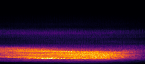

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
G 103


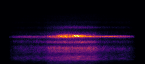

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
H 48


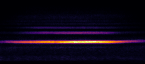

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
I 239


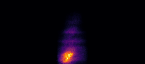

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
K 23


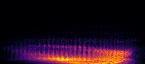

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
J 23


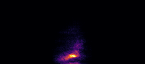

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
L 25


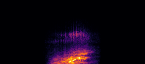

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
M 24


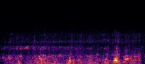

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
N 52


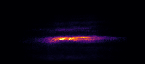

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
O 47


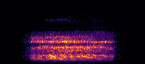

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
Q 45


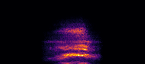

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
P 51


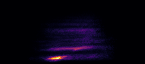

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
R 10


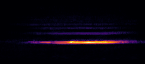

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
S 10


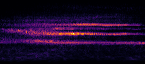

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length
T 10


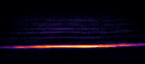

0:1.68 @ 44100Hz, 145 frames x 64 bins @ 512 hop_length


In [56]:
for unit in fingerprints_grouped:
    valid = np.asarray(units) == unit
    mean = np.median(matched[valid], 0)
    print(unit, np.sum(valid))
    specshow(np.flipud(mean.T), gamma=0.25, zoom=2)

In [44]:
for unit in fingerprints_grouped:
#     fingerprint = np.mean(fingerprints[label], 0)
    print(unit, len(fingerprints_grouped[unit]))

F 96
G 103
H 48
I 239
K 23
J 23
L 25
M 24
N 52
O 47
Q 45
P 51
R 10
S 10
T 10


In [45]:
stem_indices = to_indices(stems)

In [46]:
unit_indices = to_indices(units)
embed_2d_unit_by_unit = UMAP(min_dist=1, spread=2).fit_transform(matched.reshape(len(matched), -1), unit_indices)

In [75]:
from matplotlib.cm import rainbow, inferno

def normalize(e):
    o = e.copy()
    o -= o.min(0)
    o /= o.max()
    return o

def save_npy(fn, data):
    np.save(fn, data.astype(np.float32))
    
def get_coloring(indices, func=rainbow):
    return func(indices / (indices.max() + 1))[:,:3]

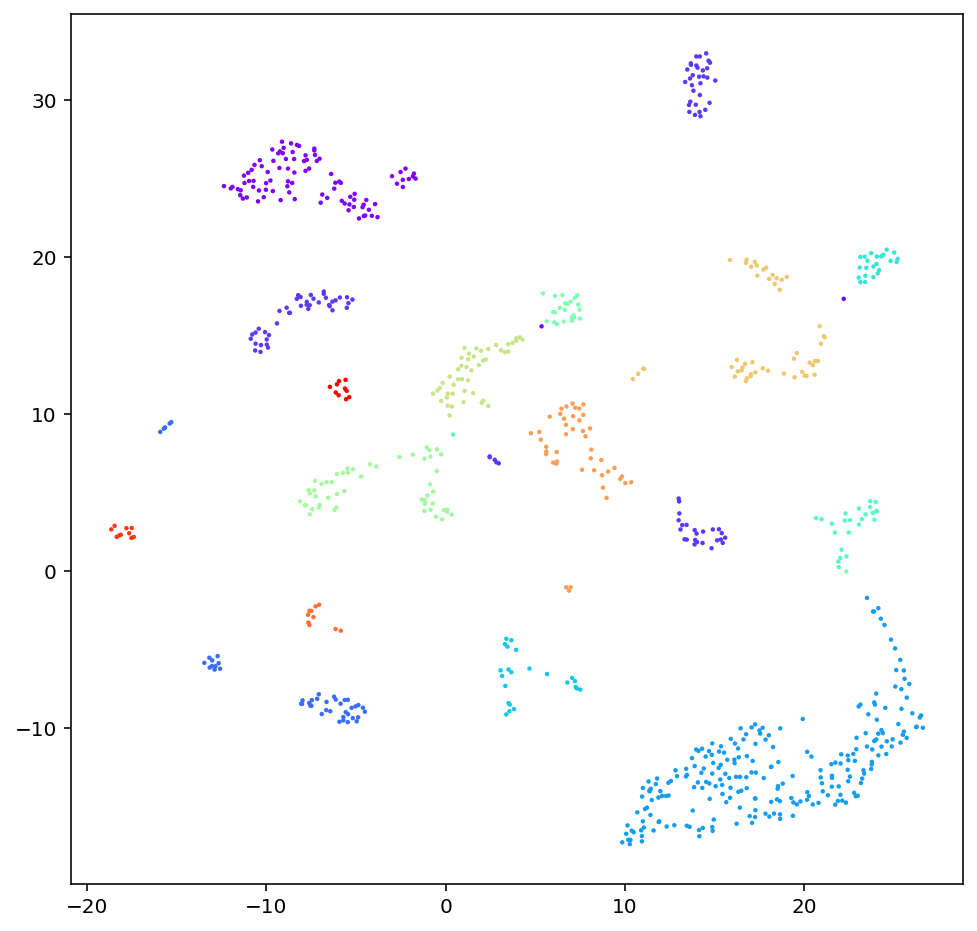

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(*embed_2d_unit_by_unit.T, c=unit_indices, cmap='rainbow', lw=0, s=5)
plt.show()

In [74]:
save_npy('export/colormap_inferno.npy', get_coloring(np.arange(1024), inferno))

In [49]:
save_npy('export/embed_2d_unit_by_unit.npy', normalize(embed_2d_unit_by_unit))
save_npy('export/color_unit_by_unit.npy', get_coloring(unit_indices))
save_npy('export/color_unit_by_singer.npy', get_coloring(stem_indices))

In [50]:
def get_strided(x):
    a = np.roll(x, shift=-1, axis=0)
    a[-1] = 0
    b = np.roll(matched, shift=+1, axis=0)
    b[0] = 0
    return np.hstack((a,x,b))

In [51]:
strided = get_strided(matched)

In [52]:
unit_indices = to_indices(units)
embed_2d_unit_by_strided = UMAP(init=embed_2d_unit_by_unit, min_dist=1, spread=2).fit_transform(strided.reshape(len(strided), -1), unit_indices)

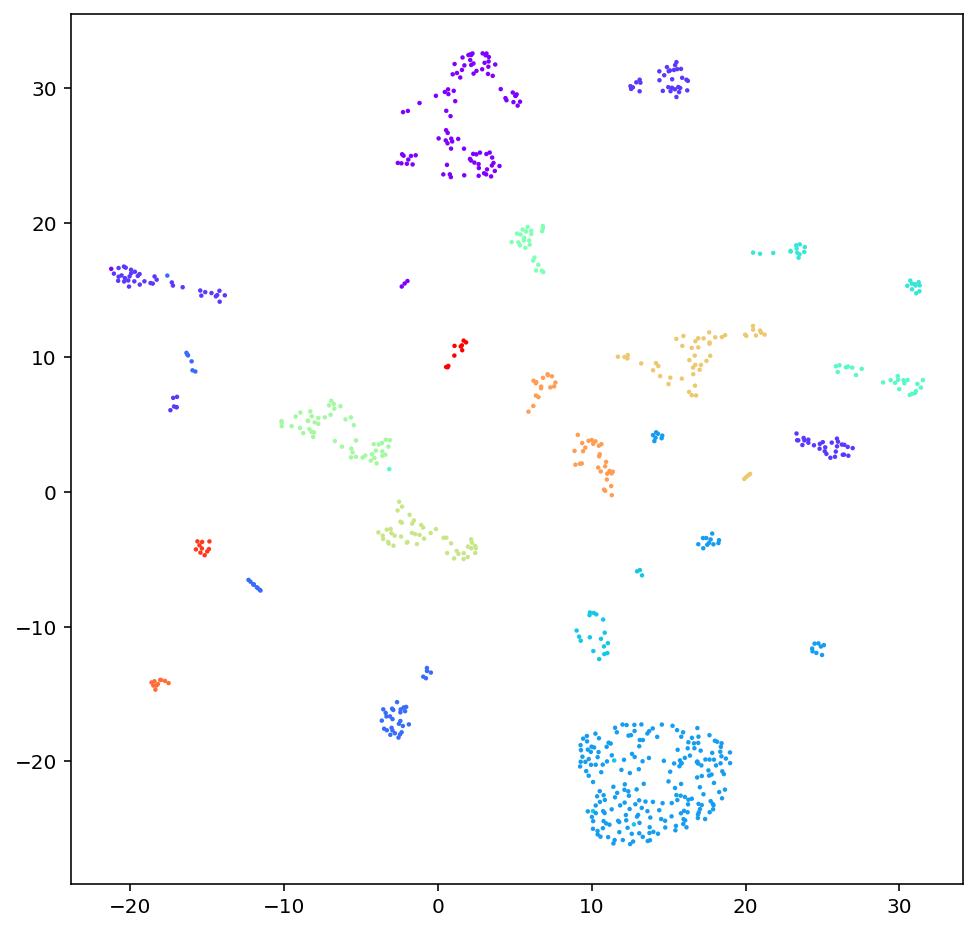

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(*embed_2d_unit_by_strided.T, c=unit_indices, cmap='rainbow', lw=0, s=5)
plt.show()

In [54]:
save_npy('export/embed_2d_unit_by_strided.npy', normalize(embed_2d_unit_by_strided))

In [68]:
for k,v in grouped.items():
    if not np.any(v['annotated']):
        continue
    save_npy(f'export/{k}-amp.npy', v['amp'])